# Zadanie 3 (7 punktów)

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry  Czwórki (ang. Connect Four).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four.

Należy zaimplementować co najmniej dwie heurystyki do ewaluacji planszy.  

Implementację algorytmu Minimax (klasa `MiniMaxSolver`) należy przetestować używając różną głębokość przeszukiwania symulując grę "komputer vs komputer". W eksperymentach należy również zademonstrować różnice pomiędzy heurystykami.  

W ramach zadania można zaimplementować dowolną liczbę dodatkowych metod w klasie `MiniMaxSolver`.

Punktacja:

- Działająca metoda Minimax oraz heurystyki do ewaluacji planszy. - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta. - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania - wykresy. - **2pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów
- Jakość kodu. - **1.5pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [31]:
from typing import Tuple, List, Callable, Any, Optional

import random
import copy

from matplotlib import pyplot as plt

from two_player_games.player import Player
from two_player_games.games.connect_four import ConnectFour, ConnectFourMove, ConnectFourState

Wielkość planszy

In [32]:
ROW_COUNT = 6
COLUMN_COUNT = 7

In [33]:
class Heuristic:
    @staticmethod
    def board_evaluation(game: ConnectFour, player: Player):
        """
        Evaluation based on heuristic table

        https://softwareengineering.stackexchange.com/questions/263514/why-does-this-evaluation-function-work-in-a-connect-four-game-in-java

        """

        sum_value = 0

        for col_idx, column in enumerate(game.state.fields):
            for row_idx, field in enumerate(column):
                    if field is not None:
                        if field.char == player.char:
                            sum_value += Heuristic.get_position_value(row_idx, col_idx)
                        else:
                            sum_value -= Heuristic.get_position_value(row_idx, col_idx)

        # print(f"Score: {sum_value}")
        return sum_value

    @staticmethod
    def get_position_value(row_idx, col_idx):
        eval_table = [
            [3, 4, 5, 7, 5, 4, 3],
            [4, 6, 8, 10, 8, 6, 4],
            [5, 8, 11, 13, 11, 8, 5],
            [5, 8, 11, 13, 11, 8, 5],
            [4, 6, 8, 10, 8, 6, 4],
            [3, 4, 5, 7, 5, 4, 3]
        ]
        return eval_table[row_idx][col_idx]

    @staticmethod
    def winning_lines_evaluation(game: ConnectFour, player: Player):
        """
        Evaluation based on the winning lines
        """

        sum_value = 0

        for col_idx, column in enumerate(game.state.fields):
            for row_idx, field in enumerate(column):
                    if field is not None:
                        if field.char == player.char:
                            sum_value += 1
                        else:
                            sum_value -= 1

        # print(f"Score: {sum_value}")
        return sum_value



In [34]:
class MinMaxSolver:

    def __init__(self, game: ConnectFour, heuristic: Callable[[ConnectFour, Player], Any], max_depth: int):
        self.game = game
        self.heuristic = heuristic
        self.max_depth = max_depth

    def get_best_move(self)->int:
        alpha = float("-inf")
        beta = float("inf")
        move, _ = self.minimax(0, alpha, beta, is_maximizing_player=True)

        return move if move else random.choice(self.game.get_moves())

    def is_valid_move(self, col_index:int)->bool:
        return col_index in self.game.get_moves()

    def minimax(self, depth, alpha:float, beta:float, is_maximizing_player:bool)-> Tuple[int, float]:
        """Returns column index and score"""

        if depth == self.max_depth or self.game.is_finished():
            return None, self.heuristic(self.game, self.game.first_player if is_maximizing_player else self.game.second_player)


        best_move: Optional[int] = None

        if is_maximizing_player:

            best_score = float("-inf")

            for move in self.game.get_moves():
                previous_state = copy.deepcopy(self.game.state)
                self.game.make_move(move)

                _, score = self.minimax(depth + 1, alpha, beta, False)

                self.game.state = previous_state

                # print(f"Max: Depth: {depth}, Move: {move.column}, Score: {score}, Alpha: {alpha}, Beta: {beta}")

                if score > best_score:
                    best_score = score
                    best_move = move

                alpha = max(alpha, best_score)
                if beta < alpha:
                    break

            return best_move, best_score

        else:

            best_score = float("inf")

            for move in self.game.get_moves():
                previous_state = copy.deepcopy(self.game.state)
                self.game.make_move(move)

                _, score = self.minimax(depth + 1, alpha, beta, True)

                self.game.state = previous_state

                # print(f"Min: Depth: {depth}, Move: {move.column}, Score: {score}, Alpha: {alpha}, Beta: {beta}")

                if score < best_score:
                    best_score = score
                    best_move = move

                beta = min(beta, best_score)
                if beta < alpha:
                    break

            return best_move, best_score

In [ ]:
class GameSimulator:

    def __init__(self, max_depth: int = 6, games_num: int = 10):
        self.games_num = games_num
        self.max_depth = max_depth

    def initialize_results(self):

        return {
            depth:
            {
                "player1_wins": 0,
                "player2_wins": 0,
                "ties": 0
            }

            for depth in range(0, self.max_depth+1)
        }

    def simulate_games(self, heuristic: Callable):

        results = self.initialize_results()

        for depth in range(1, self.max_depth + 1):
            for i in range(self.games_num):
                p1 = Player("a")
                p2 = Player("b")

                if i % 2 == 0:
                    first_player = p1
                    second_player = p2
                else:
                    first_player = p2
                    second_player = p1

                game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=first_player, second_player=second_player)

                first_solver = MinMaxSolver(game, heuristic, depth)
                second_solver = MinMaxSolver(game, heuristic, depth)

                current_player = first_player
                current_solver = first_solver

                while not game.is_finished():
                    best_move = current_solver.get_best_move()
                    game.make_move(best_move)

                    print(game)

                    if current_player == first_player:
                        current_player = second_player
                        current_solver = second_solver
                    else:
                        current_player = first_player
                        current_solver = first_solver

                winner = game.get_winner()
                if winner is not None:
                    print(f"Winner is {winner.char}")
                else:
                    print("It's a tie!")

                if winner and winner.char == game.first_player.char:
                    results[depth]["player1_wins"] += 1
                elif winner and winner.char == game.second_player.char:
                    results[depth]["player2_wins"] += 1
                else:
                    results[depth]["ties"] += 1

        return results

    def plot(self, results):
        depths = list(results.keys())
        player1_wins = [results[depth]["player1_wins"] for depth in depths]
        player2_wins = [results[depth]["player2_wins"] for depth in depths]
        ties = [results[depth]["ties"] for depth in depths]

        plt.figure(figsize=(10, 6))
        plt.plot(depths, player1_wins, label="Player 1 Wins", marker='o')
        plt.plot(depths, player2_wins, label="Player 2 Wins", marker='s')
        plt.plot(depths, ties, label="Ties", marker='^')
        plt.xlabel("Search Depth")
        plt.ylabel("Number of Games")
        plt.title("Game Outcomes vs Search Depth")
        plt.legend()
        plt.grid(True)
        plt.show()




Rozgrywka

In [36]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)
game.make_move(ConnectFourMove(3))
game.make_move(ConnectFourMove(4))
game.make_move(ConnectFourMove(3))
game.make_move(ConnectFourMove(3))
game.make_move(ConnectFourMove(3))

print(game)

Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][a][b][ ][ ]


Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a][ ][ ][b][ ][ ][ ]
[a][a][ ][b][ ][ ][a]
Winner is b
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[b][ ][ ][a][ ][ ][ ]
[b][b][ ][a][ ][ ][b]
Winner is a
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a][ ][ ][b][ ][ ][ ]
[a][a][ ][b][ ][ ][a]
Winner is b
Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[ ][ ][ ][a][ ][ ][ ]
[b][ ][ ][a][ ][ ][ ]
[b][b][ ][a][ ][ ][b]
Winner is a
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[ ][ ][ ][b][ ][ ][ ]
[a][ ][ ][b][ ][ ][ ]
[a][a][ ][b][ ][ ][a]
Winner is b
Current player: b
[b][b][ ][ ][ ][b][b]
[b][b][ ][ ][ ][b][a]
[a][b][a][ ][a][a][a]
[a][a][a][ ][a][a][b]
[b][a][a][ ][a][a][b]
[b][a][b][a][b][b][b]
Winner is a
Current player: a
[a][a][ ][

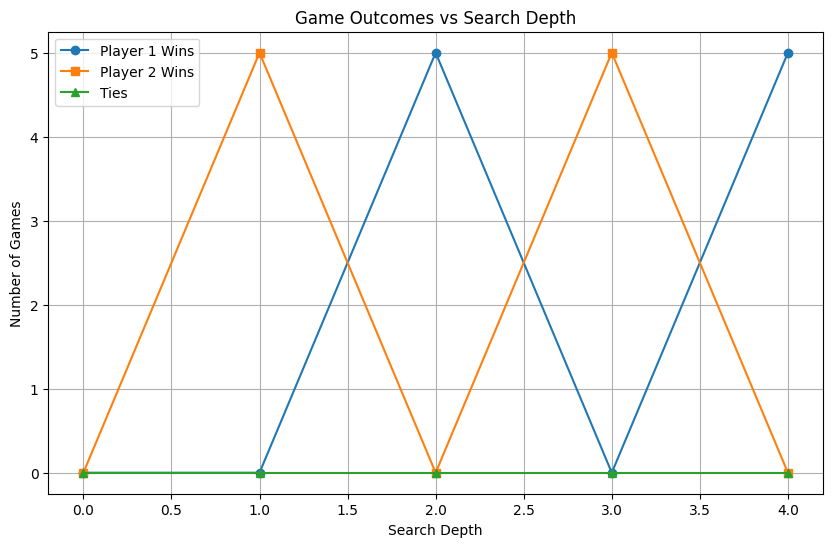

In [37]:
simulator = GameSimulator(4, 5)
results = simulator.simulate_games(Heuristic.board_evaluation)
print(results)
simulator.plot(results)

Current player: b
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][a][ ][ ][ ]
Winner is a
Current player: a
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][b][ ][ ][ ]
Winner is b
Current player: b
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][a][ ][ ][ ]
Winner is a
Current player: a
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][b][ ][ ][ ]
Winner is b
Current player: b
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][ ][ ][ ][ ]
[b][b][b][ ][ ][ ][ ]
[a][a][a][a][ ][ ][ ]
Winner is a
Current player: a
[b][b][b][a][b][b][b]
[a][a][a][b][a][a][a]
[b][b][b][a][b][b][b]
[a][a][a][b][a][a][a]
[b][b][b][a][b][b][b]
[a][a][a][b][a][a][a]
It's a tie!
Current player: b
[a][a][a][

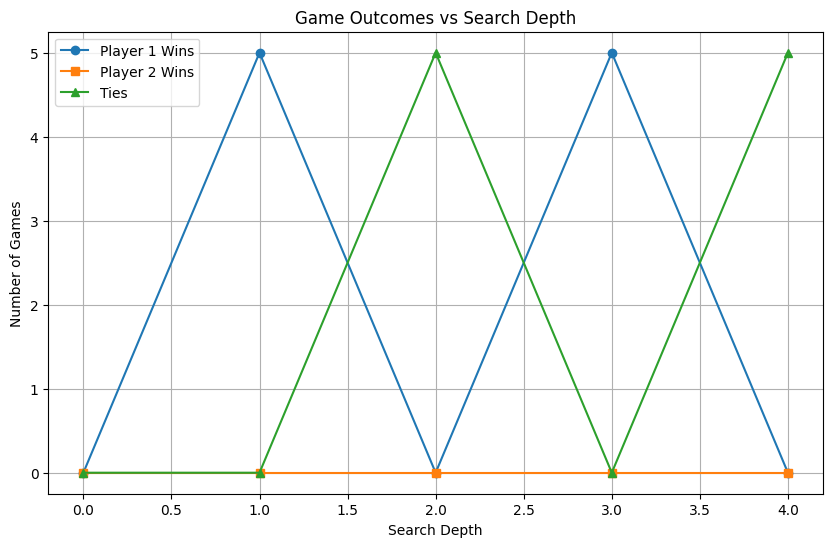

In [38]:
simulator = GameSimulator(4, 5)
results = simulator.simulate_games(Heuristic.winning_lines_evaluation)
simulator.plot(results)